---
<h1 style="text-align: center;">
MNIST Classification with Convolutional Neural Networks and Dimensionality Reduction Using PCA
</h1>

<h1 style="text-align: center;">
Task 6
</h1>

<h3 style="text-align: center;">
Dec-10-2024
</h3>

---

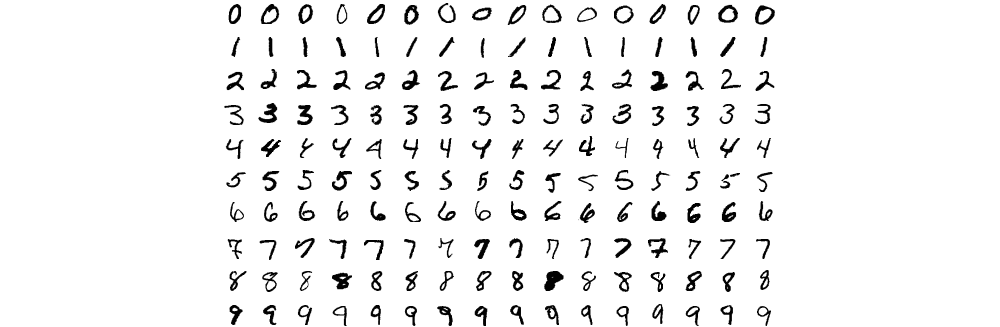

Image from https://en.wikipedia.org/wiki/MNIST_database

### **Problem 1. (75 points)** In this problem, your task is to build and train a convolutional neural network (CNN) to classify hand-written digits. We will use the MNIST dataset where each data point is an image of a hand-written digit and its label indicates the value of the digit written ($0, 1, \dots, 9$). Use the provided code (in `task6_utils.py`) to load and normalize the data (you do not need to do any other preprocessing). Your CNN must have the following architecture:
- #### Input: 1-channel input image of size 28x28 pixels
- #### Convolution layer: Convolution kernel of size (3, 3) with a stride of 1, dilation of size 1, and bias. Number of input channels: 1; Number of output channels: 20; Do not use any padding
- #### ReLU activation function
- #### Max pool: 2x2 kernel size with stride of 2
- #### Dropout layer with probability $p=0.50$
- #### Flatten input for fully-connected layers
- #### Fully-connected layer 1. Input is flattened output from conv layer with bias; Number of output nodes: 128
- #### ReLU activation function
- #### Dropout layer with probability $p=0.50$
- #### Fully-connected layer 2: Number of input nodes: 128 and bias; Number of output nodes: 10
- #### Softmax activation function on output layer (note, you do not need to specify this anywhere, it is included when using cross entropy loss `torch.nn.CrossEntropyLoss()`.

### Train your CNN for $N$ epochs (you must decide $N$) on all the training data using vanilla SGD (e.g., `torch.optim.SGD()`) as the optimizer with mini batches of size 32 images and cross entropy loss (e.g., `torch.nn.CrossEntropyLoss()`). In each epoch, print out the cumulative training loss, training error rate, cumulative test loss, and test error rate. Once training has converged (you must decide when this happens), apply your learned model to the test set one last time and print out the cumulative test loss and test error rate. Also, randomly select 5 images which your model incorrectly predicted and plot the images. What is the correct label and what is the label your network predicted for each of the 5 images? Why do you think your model misclassified these images? 

### Write your code and display your figures here

In [1]:
import os
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


In [2]:
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from data.task6_utils import load_MNIST

# Set random seeds for reproducibility
np.random.seed(2024)
torch.manual_seed(2024)

# Load the data
batch_size = 32
normalize_vals = (0.1307, 0.3081)
dropout_prob = 0.5
num_epochs = 15
train_dataset, test_dataset, train_loader, test_loader = load_MNIST(batch_size, normalize_vals)

print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 60000
Number of test samples: 10000


In [3]:
# Define the CNN Model
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, stride=1, dilation=1, bias=True)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.fc1 = nn.Linear(20 * 13 * 13, 128, bias=True)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(128, 10, bias=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)  
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = MyCNN()

print(model)

MyCNN(
  (conv): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3380, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) 

def calculate_error_rate(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds != labels).sum().item() / labels.size(0)

train_losses, train_errors = [], []
test_losses, test_errors = [], []

for epoch in range(num_epochs):
    model.train()
    cumulative_train_loss = 0.0
    cumulative_train_error = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumulative_train_loss += loss.item() * images.size(0)
        cumulative_train_error += calculate_error_rate(outputs, labels) * images.size(0)

    # Losses and error rates
    train_losses.append(cumulative_train_loss / len(train_loader.dataset))
    train_errors.append(cumulative_train_error / len(train_loader.dataset))

    # Evaluating on the test set
    model.eval()
    cumulative_test_loss = 0.0
    cumulative_test_error = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss and error
            cumulative_test_loss += loss.item() * images.size(0)
            cumulative_test_error += calculate_error_rate(outputs, labels) * images.size(0)

    test_losses.append(cumulative_test_loss / len(test_loader.dataset))
    test_errors.append(cumulative_test_error / len(test_loader.dataset))

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {train_losses[-1]:.4f}, Training Error: {train_errors[-1]:.4f}")
    print(f"Test Loss: {test_losses[-1]:.4f}, Test Error: {test_errors[-1]:.4f}")

Epoch 1/15
Training Loss: 0.5220, Training Error: 0.1600
Test Loss: 0.1857, Test Error: 0.0553
Epoch 2/15
Training Loss: 0.2762, Training Error: 0.0835
Test Loss: 0.1201, Test Error: 0.0368
Epoch 3/15
Training Loss: 0.2139, Training Error: 0.0648
Test Loss: 0.0957, Test Error: 0.0292
Epoch 4/15
Training Loss: 0.1821, Training Error: 0.0553
Test Loss: 0.0801, Test Error: 0.0248
Epoch 5/15
Training Loss: 0.1615, Training Error: 0.0493
Test Loss: 0.0713, Test Error: 0.0226
Epoch 6/15
Training Loss: 0.1485, Training Error: 0.0449
Test Loss: 0.0649, Test Error: 0.0205
Epoch 7/15
Training Loss: 0.1392, Training Error: 0.0423
Test Loss: 0.0605, Test Error: 0.0199
Epoch 8/15
Training Loss: 0.1304, Training Error: 0.0391
Test Loss: 0.0572, Test Error: 0.0184
Epoch 9/15
Training Loss: 0.1236, Training Error: 0.0376
Test Loss: 0.0537, Test Error: 0.0181
Epoch 10/15
Training Loss: 0.1156, Training Error: 0.0354
Test Loss: 0.0526, Test Error: 0.0181
Epoch 11/15
Training Loss: 0.1133, Training Error

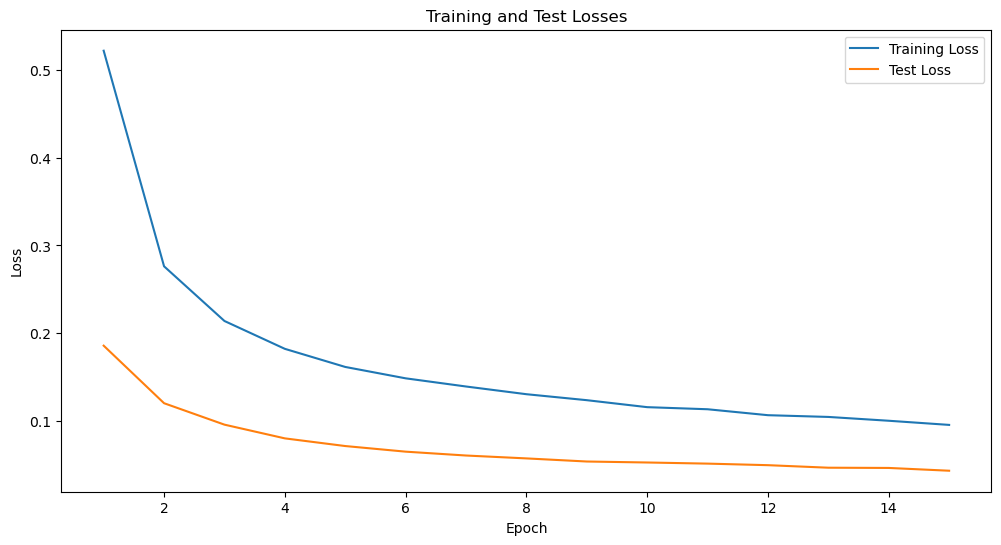

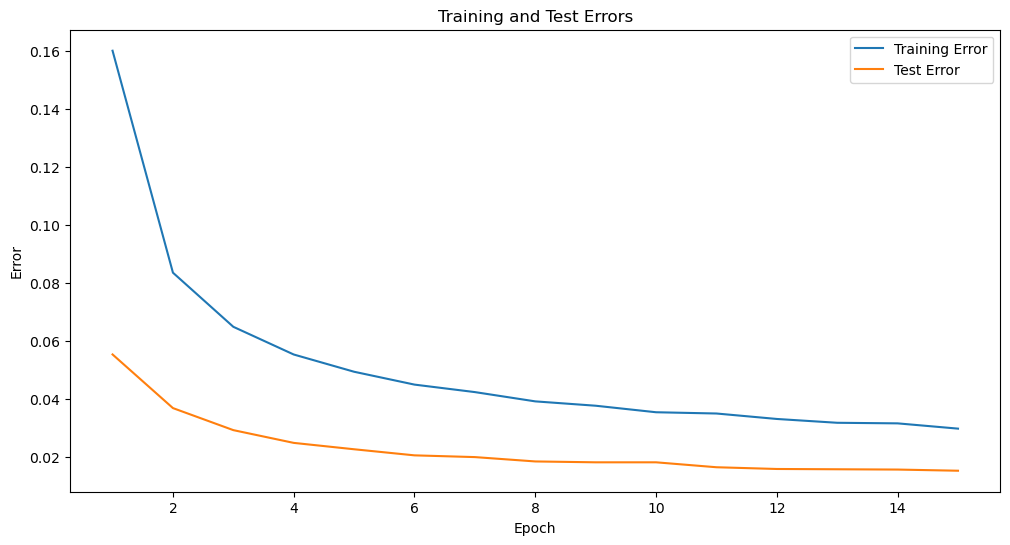

In [5]:
# Plotting training and testing losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Losses")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_errors, label="Training Error")
plt.plot(range(1, num_epochs + 1), test_errors, label="Test Error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training and Test Errors")
plt.legend()
plt.show()

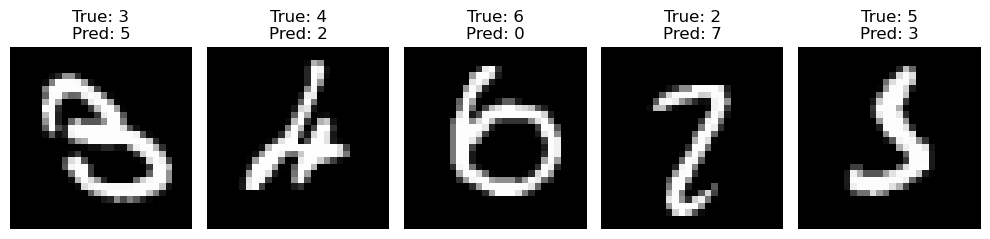

In [13]:
# Plot 5 misclassified images
model.eval()
misclassified_images = []
misclassified_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if len(misclassified_images) >= 5:
                break
            if preds[i] != labels[i]:
                misclassified_images.append(images[i].cpu().numpy().squeeze())
                misclassified_labels.append(labels[i].item())
                predicted_labels.append(preds[i].item())

# Plot the misclassified images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(misclassified_images[i], cmap="gray")
    plt.title(f"True: {misclassified_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
# Print final test loss and error rate
final_test_loss = test_losses[-1]
final_test_error = test_errors[-1]
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Error Rate: {final_test_error:.4f}")

Final Test Loss: 0.0432
Final Test Error Rate: 0.0152


### Answer the text questions here

## MNIST Dataset Report

### Loading and Normalizing Data
- Switched to mps device for GPU use using PyTorch.
- First, used the hw6_utils.py to load the dataset and do the preprocessing by converting them to PyTorch tensors.
- Introduced the batch size = `32`, dropout probability = `0.5`, epochs = `15` and normalize vals.
- Then, Normalized the images with the `0.1307` mean and `0.3081` standard deviation.
- Introduced DataLoader objects for training and testing using `load_MNIST`.
- Printed out the Training samples = `60000` and Testing samples = `10000`.


### Build the Model Architecture
- Built the required CNN model using the MNIST dataset using the given paramters and requirements.
- Printed out the model architecture to confirm the given values and show the model.
- This was what the main architecture of the model looks like -
- `Conv2d -> ReLU -> MaxPool2d ->  Dropout -> Linear -> ReLU -> Dropout -> Linear`


### Training the Model
- Started off with training the model on `CrossEntropyLoss()` and then using `optim.SGD` optimizer.
- Used a learning rate of 0.1 for faster training
- Further the model was trained on 15 epochs using:
- Forward Pass -> Calculating Loss using `CrossEntropyLoss` -> Backward Pass using loss.backward() -> Updating the Paramters using `optimizer.step()` -> Clearing Zero Gradients using `optimizer.zero_grad()`.
- This is the version of the epoch result:

- Epoch 1/15
Training Loss: 0.5220, Training Error: 0.1600
Test Loss: 0.1857, Test Error: 0.0553
- Epoch 2/15
Training Loss: 0.2762, Training Error: 0.0835
Test Loss: 0.1201, Test Error: 0.0368
- Epoch 3/15
Training Loss: 0.2139, Training Error: 0.0648
Test Loss: 0.0957, Test Error: 0.0292
- Epoch 4/15
Training Loss: 0.1821, Training Error: 0.0553
Test Loss: 0.0801, Test Error: 0.0248
- Epoch 5/15
Training Loss: 0.1615, Training Error: 0.0493
Test Loss: 0.0713, Test Error: 0.0226
- Epoch 6/15
Training Loss: 0.1485, Training Error: 0.0449
Test Loss: 0.0649, Test Error: 0.0205
- Epoch 7/15
Training Loss: 0.1392, Training Error: 0.0423
Test Loss: 0.0605, Test Error: 0.0199
- Epoch 8/15
Training Loss: 0.1304, Training Error: 0.0391
Test Loss: 0.0572, Test Error: 0.0184
- Epoch 9/15
Training Loss: 0.1236, Training Error: 0.0376
Test Loss: 0.0537, Test Error: 0.0181
- Epoch 10/15
Training Loss: 0.1156, Training Error: 0.0354
Test Loss: 0.0526, Test Error: 0.0181
- Epoch 11/15
Training Loss: 0.1133, Training Error: 0.0349
Test Loss: 0.0513, Test Error: 0.0164
- Epoch 12/15
Training Loss: 0.1065, Training Error: 0.0331
Test Loss: 0.0495, Test Error: 0.0158
- Epoch 13/15
Training Loss: 0.1045, Training Error: 0.0317
Test Loss: 0.0466, Test Error: 0.0157
- Epoch 14/15
Training Loss: 0.1002, Training Error: 0.0315
Test Loss: 0.0464, Test Error: 0.0156
- Epoch 15/15
Training Loss: 0.0954, Training Error: 0.0297
Test Loss: 0.0432, Test Error: 0.0152


### Logged losses and error rates
- During each epoch of training, I printed out the: Training Loss, Testing Loss, Training Error Rate, and Testing Error Rate.
- These were required to be printed and helped to evaluate how well the model have performed throughout the process. With each epoch, the training and testing error decreased. Observing the test loss and error also help to see if the model was overfitting or not, and see its generalization.
- The model showed a fast decrease in the first few epochs and then managed to converge quickly and slow down the decrease rate. The final error and losses were pretty much similar but did show how well the model has converged.  


### Decided on Epochs
- I chose N=15 as a starting point. The MNIST converged quickly and I think choosing between 10-20 would be alright for this dataset. Convergencene happened when the test loss/error decreased severely. If the model converged ineffieciently, it could have been trained for more epochs, but choosing these 15 epochs worked well for the model


### Plot the Misclassified Images and Explain Mistakes
- After the training process was completed, the model was evaluated and identified 5 images, that were incorrectly classified as different predictions.
- Then, these images were plotted and both their correct and incorrect labels were printed out. Like, for example, the results were that:
#### Q) What is the correct label and what is the label your network predicted for each of the 5 images? Why do you think your model misclassified these images?
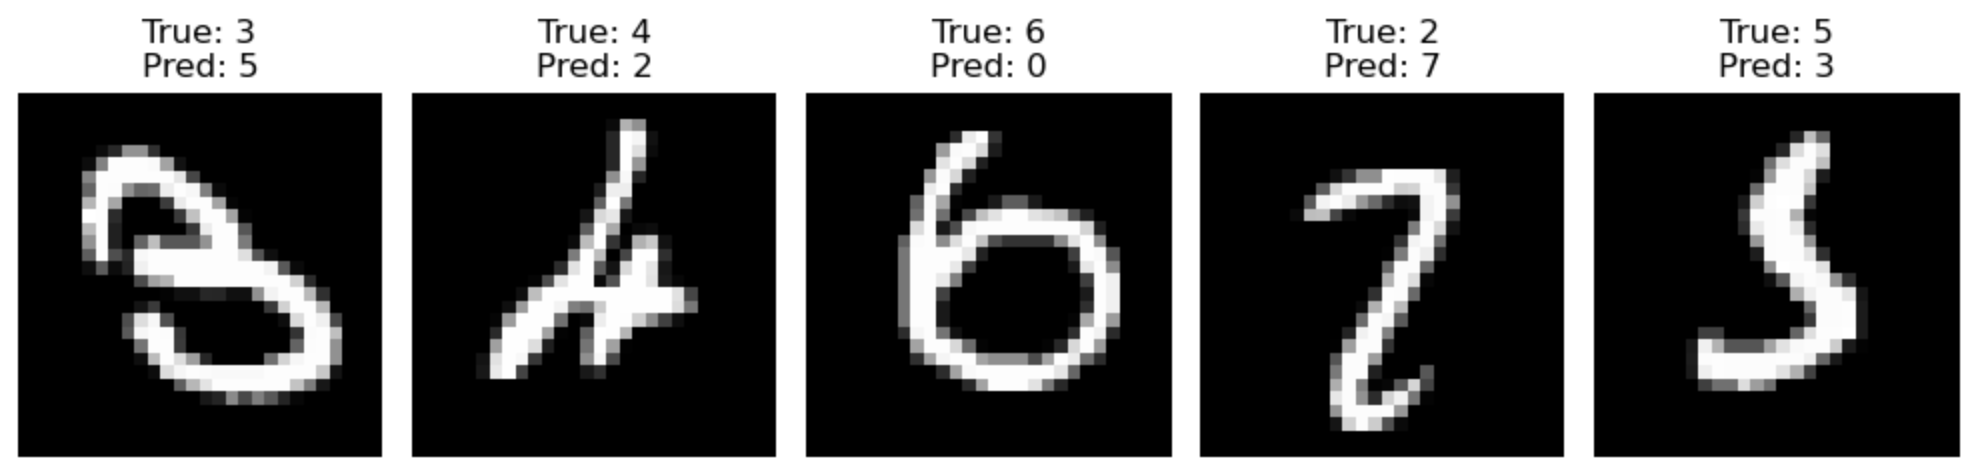

##### Image 1: The correct label is `3` and the incorrect label is `5`.
- The number "3" is generally made up of two curved segments, one on top of the other, but if either the upper or lower loop does not fully form, it may look like a "5". The top part of 3 appears to be angled, and makes the model think that the top part of the shape looks liek a "5". The bottom part of "3" looks almost completely identical to a "5". It is not appearing to be clear when the structure is drawn out. If the bottom curve is not closed, the digit could be a "5". The thickness of the shape as well can change how the model identifies the edges. A slighly thicker or smudged line at the top could appear to be different from the intended form. The incomplete loops also plays a part in the answer. The handwritten image also have certain segements where the top and lower part could be flipped and look like a "5".

##### Image 2: The correct label is `4` and the incorrect label is `2`.
- The digit "4" typically consists of a vertical line joined by a diagonal drawing and a horizontal ending, creating a distinct open space in its upper portion. However, if this structure is not clearly formed, the diagonal stroke is more curved than angular, or if the open space is not well defined the "4" may start to resemble a "2". Instead of seeing a strong, angular shape with a clear internal gap, the model observes a shape that is more fluid and rounded. This can cause the distinctive corners of "4" to blend together into the smooth, arch-like curve characteristic of a "2". Thicker or smudged lines can further obscure the sharp angles, and subtle pixelation might erode the straight edges. As a result, what should be a rigid structure looks more continuous and rounded, prompting the network to classify it as a "2".
  
##### Image 3: The correct label is `6` and the incorrect label is `0`.
- A "6" generally has a looped upper part connected to a distinct lower curve, making it look like a circle with a tail or a notch. If this loop is drawn too symmetrically and without a clear break or tail, it begins to resemble the perfect oval shape of a "0". Without a small protrusion or angled entry point to differentiate it from a complete loop, the model sees a uniform circular shape. Slight smudging or uneven thickness can cause the inner space of the "6" to close up, making it appear as a fully enclosed loop. Without a clear internal angle or variation in width, the digit loses the unique curvature that distinguishes it from "0". As a result, the handwritten "6" can appear as nothing more than a clean, simple oval, leading the network to misinterpret it as "0".

##### Image 4: The correct label is `2` and the incorrect label is `7`.
- The number "2" is often drawn with a upper curve and a horizontal base line, creating a smooth, semi-circular top followed by a descending stroke and a stable baseline. If the upper curve is not distinct, or if the horizontal line at the bottom is missing or incomplete, the digit takes on a more angular shape, resembling a "7". The lack of a curve at the top and the absence of a well-defined bottom stroke can leave the digit looking like a simple angled line descending from a flat top segment. Thicker lines, or slight misalignment can diminish the smooth that define "2". Without a clear curved structure, the handwritten shape mimics a more linear design, making the model perceive it as a "7" instead of a "2".
  
##### Image 5: The correct label is `5` and the incorrect label is `3`.
- The digit "5" generally has a top horizontal line and a distinct angled or curved transition into its lower part. If that top segment is not drawn clearly, or if the transitions between strokes are too smoothly curved, the "5" can resemble a "3" made of two loops. Instead of sharp angles or a flat top, the model may see continuous curves that connect each portion of the shape. Without a clear horizontal line or a break in the strokes, the form loses the angularity of a "5" and adopts the more flowing, looped structure of a "3". Unclear boundaries, smudged lines can make the upper part appear curved rather than straight, thus changing the digit’s appearance and confusing the model into seeing a "3" where a "5" was intended.

- To conclude, each misclassification here occurred because the handwritten digits didn’t clearly show the distinctive shapes the model learned for each number. Subtle differences like a missing horizontal stroke, a curve drawn or thick linw can cause the shape to resemble another digit. As a result, the model, relies on visual patterns, mistakes unclear handwriting features for a different number’s signature shape. This shows how even small variations in handwriting style can confuse a neural network trained to recognize simple forms.


### Final Model Performance
- The model correctly worked and showed the misclassified images with the entrie dataset.
- The final loss and error rate comes out to be
    - Final Test Loss: `0.0432` and Final Error Rate: `0.0152` or `1.52%`
- This means that the `1.52%` error rate on the test set, which is great for the simple network used here, works with good generalization and less overfitting. The training done on a more advanced model would result in lower error rates, but in this assignment, the performance works great and is well within the acceptable range.

---

### **Problem 2. (25 points)** In this problem, your task is to apply principal component analysis (PCA) to the MNIST dataset to reduce the dimensionality of each image from 784 to 2 and visualize the images in the lower-dimensional subspace. Apply PCA to all the training data to learn the projection vector. Then, project each image in the training dataset to $\mathbb{R}^2$. Use the provided plotting function `plot_points()` (in `task6_utils.py`) to plot each projected image as a point in a 2-dimensional figure where the x-axis is principal component 1 and the y-axis is principal component 2. Color each point in the figure according to the label of each image so we can visualize how well PCA reduced the dimensionality according to how closely the images are grouped by label. (Note, only use the labels to visualize how well PCA did, do not use the labels anywhere else.) What are your observations from the figure? Where did PCA reduce the dimensionality well and where did it not do well? Note, you may get some complex numbers when computing the eigenvalues and eigenvectors. You can use `np.real()` to only keep the real part. 


### Write your code and display your figures here

In [8]:
from data.task6_utils import load_MNIST, convert_data_to_numpy, plot_points

np.random.seed(2024)

normalize_vals = (0.1307, 0.3081)

batch_size = 100

train_dataset, test_dataset, train_loader, test_loader = load_MNIST(batch_size, normalize_vals)

X, y = convert_data_to_numpy(train_dataset)  

In [9]:
# PCA on this dataset
# Preprocessing the data
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean
cov_matrix = np.cov(X_centered, rowvar=False)

In [10]:
# Eigen decomposition
eigen_vals, eigen_vecs = np.linalg.eigh(cov_matrix)

# Keeping the real part
eigen_vals = np.real(eigen_vals)
eigen_vecs = np.real(eigen_vecs)

# Sorting them in descending order
sort_eigen = np.argsort(eigen_vals)[::-1]
eigen_vals = eigen_vals[sort_eigen]
eigen_vecs = eigen_vecs[:, sort_eigen]

W = eigen_vecs[:, :2]  # shape is: (784, 2)

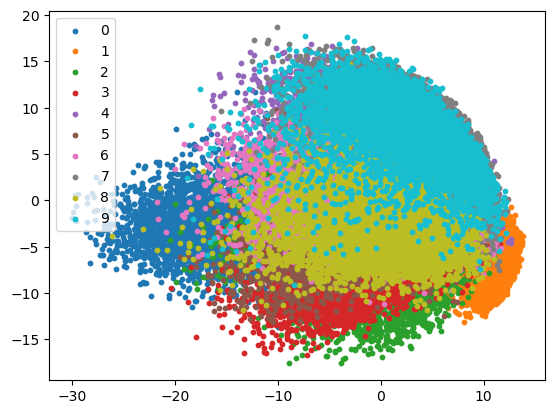

In [11]:
# Using data on these 2 components
X_2D = X_centered.dot(W)
points_x = X_2D[:, 0]
points_y = X_2D[:, 1]

# Plotting the PCA here
plot_points(points_x, points_y, y, filename="pca_mnist.png")

### Answer the text questions here

### What are your observations from the figure? 

#### Clustered and Distinct Digits ex "0"
- Some digits have easily recognizable features, like as the closed loop characteristic of `0` which forms a cluster in the 2D PCA space. These shapes are relatively easily to idenitfy becuase of their dominant difference from other numbers, resulting in spaces where points of the same digit stand out from the rest of the numbers.

- The digit `0` also stands out because of its smooth, round shape without any sharp angles. This makes it less affected by different handwriting styles compared to other digits. PCA captures these clear features well, which is why 0 forms a distinct and separate cluster in the graph. Even if 0 is written quickly or messily, the basic loop structure usually stays the same. It could be consufed for `6` in some cases when the upward line is overdrawn but thats about it. The clear separation of 0 also shows how PCA highlights big differences in the dataset. This also makes 0 a good example for understanding how unique shapes can either form clear clusters or mix with others.

#### Overlap Among Curved and Mixed Digits (e.g., "3," "5," "8," "9", "6"):
- A large set of the digits are curved or semi curved and digits like `3`, `5`, `8`, `9`, and `6` show overlapping clusters because of their curvature patterns and are not easily differentable sometimes by the 2d components. These digits blend together in one continuous, big cloud instead of separate clusters in the PCA projection because the directions of highest variance do not line up well with the more small differences in shape that distinguish the individual digits.

- Many curved digits, like 3, 5, 8, 9, and 6, have shapes that are quite similar. For example, 6 and 9 look like flipped versions of each other, and 3 and 8 share loops. Because of these similarities, their clusters overlap a lot in the 2D space. Their overlap becomes even more noticeable when people write these digits in different styles. A slightly messy version of these numbers can make it hard for PCA to separate them. While PCA works well for finding big patterns, it struggles with smaller details that make these digits different. 

#### Line and Angle-Based Digits (e.g., "1," "4," "7", "2"):
- These digits are shown by straight lines and angles, such as `1`, `4`, `7` and `2`. They are somewhat seperated from the main graph. Though, they share a linear properly, their are different ways the could be handwritten cause their points could not be perfectly linear. This leads them to partially overlap with each other and leak into some regions of curved digits. This results in some semi-overlap areas.

- Also, Straight-line digits like 1, 4, 7, and 2 are easier to separate from curved digits because they have sharp angles and straight edges. However, these digits can still overlap with each other. Like, a 7 with a slight curve at the top might look like a 2, and a poorly written 4 could look like a 1 or 7. PCA still shows the main differences between these straight-line digits and the curved ones. The mixing of clusters shows how handwriting variations can make it hard to keep these groups fully separate. 

### Where did PCA reduce the dimensionality well and where did it not do well? 

- This dimensionality reduction was effective in the sense that PCA allowed to visualize 784-dimensional data on a 2D plane.
- Digits that have more distinct and easily recognizable shapes, like `0` form their seperate clusters. The PCA does well here by identifying the large-scale difference between the directions their shapes are moving and making those digits appearing grouped in a graph.
- But what it does not do well at is seperating the digits as they do not have any boundries int he graph. Many difits have partial similarities, like cureved parts, angled strokes and line-shapes. So, they tend to overlap in the 2D projection. For example, `3`, `5` and `8` share curved features that make them blend together. While shapes like `4`, `7`, `1` and `2` have line like patterns and appear clustered. So, PCA overall gives a great maping of the data variation, though two principal components could be insufficient for the digit class to form into a tight, isolated cluster.

---

## Extra Credit Problems

### In order for extra credit solutions to be considered, you must provide reasonable solutions to all parts of Problems 1 and 2 above. If you skip any part of a problem or do not provide a reasonable solution, we will not count any extra credit towards your grade.

---

### **Extra Credit 1. (3 points)** Describe how to split the data to train a machine learning model (e.g., SVM). Make sure to describe two ways, one using cross validation and another without using cross validation. Explain why we split the data in these ways and what can happen if the data is split incorrectly.

### Answer the questions here

In any machine learning model, including the SVM, preparation of data involves holding out a part of the data for testing, so one can know how well the model generalizes on new, unseen examples. This is to prevent overfitting, so the model will memorize the examples it has been trained on rather than learning general patterns.

#### 1. `Splitting Without Cross-Validation (Train/Test Split)`

- Here what you do is randomly divide the dataset into two parts- training and testing set. For example, choosing 80 percent for training and 20% for testing is a common practive. From these, the model gets trained on the training set and then evaluated on the test set it has not seen before. This shows how it might be when it is used in real cases. This is the quick and easy method and also esures that model has atleast some data reserved for evaluation, helping to see if model is overfitting or generalizing. Here, though if the split between test and train is not done properly, the evaluation would not be accuracte. This would make the model look extremly bad than it actually is in practice. 

This is an example code 

#### 2. `Splitting With Cross-Validation`

- Here in cross-validation, it is a better way of using the data. You split the whole data into k almost equal sized parts. You then train the model k times, each time one of the parts as the dataset and the rest k-1 folds combined on the training set. The average performance across all the k runs gives a more stable and reliable performance estimate. Cross-validation works well with limited data given. Each data point thereby gets to be in a test set once and in a training set k-1 times. This also removes the concept of lucky/unlucky split between data nd gives a more dependable measure of how well the model does. But there are also some drawback here, like if the data specifically has patterns or if not shuffled, it can create some ideas. Like, if all the data in one fold has some features and the test fold has a different feature, this gives a weird estimate of the performance. So, proper randomization is important, in such cases.

This is an example code 

The data is split in these ways to track the model's performance on data it hasn't seen during training. This is also important, to avoid overfitting the model and to make sure that the model's predictions hold up well in practical situations. But, if the data is split incorrectly, and the test set contains information from the training set, this could result in bad model training. This kind of training would not be good for real-world situations and majorly mislead estimates. 

---

### **Extra Credit 2. (10 points)** In this problem, your task is to segment an image using $k$-means. We can use $k$-means to cluster pixels with similar (color) values together to generate a segmented or compressed version of the original image. Apply $k$-means to the provided image `csci.png`. For each $k=\{3,5,7\}$, generate a segmented image and compute the cumulative loss (i.e., distortion measure from the lecture notes). (Note, it may be helpful to test on a smaller version of the image `csci.png` to ensure your code works but report final results on the full version.)

### Write your code and display your figures here


Cumulative Loss (Distortion) for each K:

K=3: Distortion=10017.08

K=5: Distortion=4282.20

K=7: Distortion=2318.42



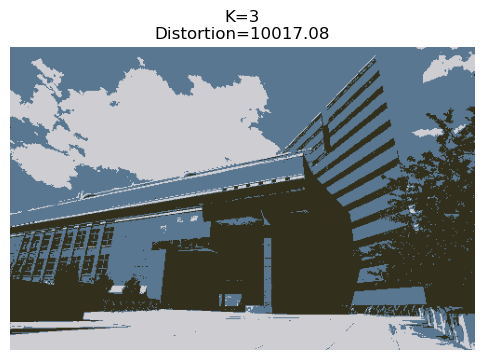

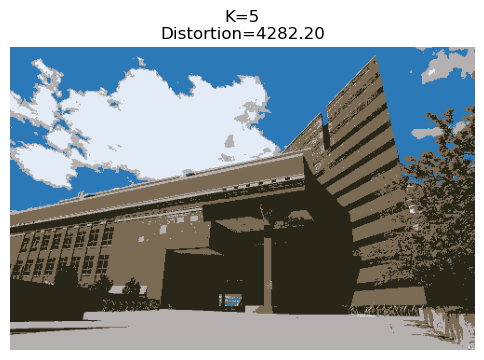

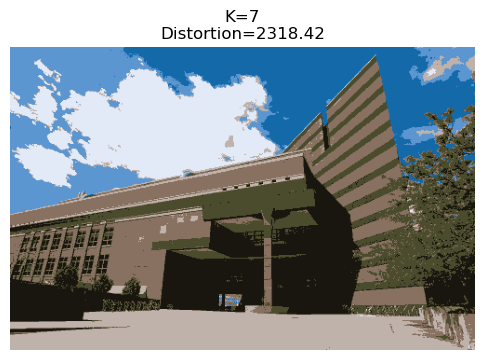

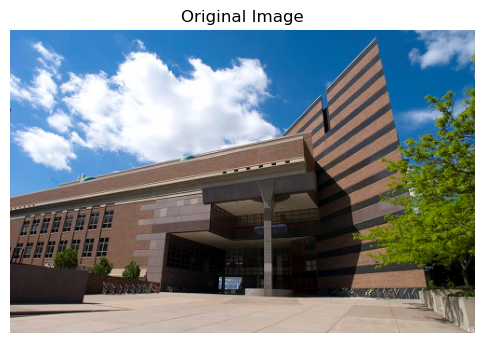

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

img = plt.imread("csci.png")  
H, W, C = img.shape

pixels = img.reshape(-1, C)

Ks = [3, 5, 7]

print("\nCumulative Loss (Distortion) for each K:\n")
distortions = []
for K in Ks:
    # Fitting K-means
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    distortion = np.sum((pixels - centroids[labels])**2)
    distortions.append(distortion)
    print(f"K={K}: Distortion={distortion:.2f}\n")

for i, K in enumerate(Ks):
    # Fiting K-means 
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Segmented image
    segmented_pixels = centroids[labels].reshape(H, W, C)
    if img.max() <= 1: 
        segmented_img = (segmented_pixels * 255).astype(np.uint8)
    else:
        segmented_img = segmented_pixels.astype(np.uint8)
    
    # Plotting the Segmented image
    plt.figure(figsize=(6, 6))
    plt.imshow(segmented_img)
    plt.axis("off")
    plt.title(f"K={K}\nDistortion={distortions[i]:.2f}")
    plt.show()

# Plotting the Original image
plt.figure(figsize=(6, 6))
if img.max() <= 1:  
    plt.imshow((img * 255).astype(np.uint8))
else:
    plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.title("Original Image")
plt.show()

## Report 

- The task was to apply K-means clustering to the umn_csci.png image in order to create segmented versions of that image. Every pixel from the picture is considered as a point in RGB-space, and K-means strives to cluster similar colors. Through replacing each pixel's color by that pixel's mean color after being assigned a cluster, I got a segmented version of the image.

- Loaded the image `umn_csci_png` and introduced certain paramters like H and W are the height and width and like Ks = `[3, 5, 7]` for th K values to compute.
- Applied the K-means and to each pixel that has a cluster label indicating to which of the K clusters it belongs.
- Found the Cummulative Loss (or Distortion) for each K and printed out the results as well.
- Segmented the images, by using cluster centroid color for clustering. This replaced each pixel of the original image to the centroid. This gives a quanitized version of only the K-colors.

### K-means segementing

- So, finally the cumulative loss shows that as the k value increases, the overall distrotion decreases. The image also starts to become somewhat like the original image. K-means seems like a great technique for pointing out specific color regions in a image. Looking at both the image and the distortion value tells us how good the given k works with the image.
- At a K=7, with 7 different color combinations, the image looks almost similar to the one in the original.

---

### For all problems, make sure to write and submit clean, working code. Reminder, you cannot use ChatGPT or similar technologies. Please see the syllabus for more details.